### Import Necessary Libraries and Set Up the Environment

In [1]:
import sys
import os

# Add the parent directory ('BNetzA') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Import custom modules
from models import *
from Data_Preprocessing.data_preprocessing import *

# Set pandas display option for floating-point numbers
pd.set_option('display.float_format', '{:.4f}'.format)


### Load and Prepare Data

In [2]:
# Load Data from the Excel file
path_to_excel = "../data/EVS4_20140118_dataV9.xlsx"
df = load_data(path_to_excel, sheet_name="DatasetV9")

# Prepare the base training and testing datasets
df_train, df_test = prepare_base_data(df)

In [3]:
# Generate variations of the training and testing datasets
df_train_list, df_test_list = create_variations(df_train, df_test)


In [4]:
# List of technical blocks variables used in the analysis
technical_blocks_variables = [
    "yCables.all.N13.sum", "yCables.all.N57.sum", "yCables.all.tot", "yCables.circuit.N3", "yCables.circuit.N5", "yCables.circuit.N7",
    "yConnections.incl.inj.N1357.sum", "yConnections.other.dso.lower.N1to6.sum", "yConnections.other.dso.same.tot",
    "yEnergy.delivered.net.N23.sum", "yEnergy.delivered.net.N2to4.sum", "yEnergy.delivered.net.N45.sum", "yEnergy.delivered.net.N5to7.sum", "yEnergy.delivered.net.N67.sum", "yEnergy.delivered.net.tot", 
    "yInjection.net.N2to4.sum", "yInjection.net.N5to7.sum", 
    "yInstalledPower.KWKG.other.tot", "yInstalledPower.N1to4.sum", "yInstalledPower.N5to6.sum", "yInstalledPower.N5to7.sum", "yInstalledPower.N7", "yInstalledPower.nonsimcurt.N1to4.sum", "yInstalledPower.nonsimcurt.N5to7.sum", "yInstalledPower.non.solar.wind.tot",
    "yInstalledPower.reducedAPFI.N1to4.sum", "yInstalledPower.reducedAPFI.N5to7.sum", "yInstalledPower.reducedAPFI.tot", "yInstalledPower.renewables.bio.hydro.tot", "yInstalledPower.renewables.solar.tot", "yInstalledPower.renewables.solar.wind.tot", "yInstalledPower.renewables.wind.tot", 
    "yLines.all.N13.sum", "yLines.all.N57.sum", "yLines.all.tot", "yLines.circuit.N3", "yLines.circuit.N5", "yLines.circuit.N7",
    "yMeters.cp.ctrl.tot", "yMeters.house.tot", "yMeters.noncp.ctrl.excl.house.tot", "yMeters.noncp.ctrl.tot", "yMeters.read.tot", 
    "yNet.length.N5", "yNet.length.N7", "yNet.length.all.tot",
    "yPeakload.N4", "yPeakload.N6", "yPeakload.abs.sim.N4", "yPeakload.from.higher.sim.N4", "yPeakload.into.higher.sim.N4", "yPeakload.into.higher.sim.nett.N6"
]

### Clustering Based on Technical Blocks Variables

In [5]:
# Select and scale only variables from the technical blocks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train[technical_blocks_variables])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to the training DataFrame
df_train['Cluster'] = clusters

# Display the count of each cluster in the training set
df_train["Cluster"].value_counts()


Cluster
 0    109
-1     65
Name: count, dtype: int64

The DBSCAN clustering results show two clusters: **Cluster 0**, which includes 109 samples, and **Cluster -1**, representing 65 samples identified as noise or outliers by the algorithm. However, using the boxplot, we can observe that the clusters exhibit strong differences based on the variables of the technical block. 

These differences suggest that **Cluster -1** may represent a cluster with more capacity and cost, potentially indicating a larger network, while **Cluster 0** appears to be a smaller network cluster. Although **Cluster -1** is generally considered noise or outliers in DBSCAN clustering, in this case, due to the large range of values, many providers fall into this category, justifying the formation of this cluster.


### Visualize Distribution of Technical Blocks Variables Across Clusters

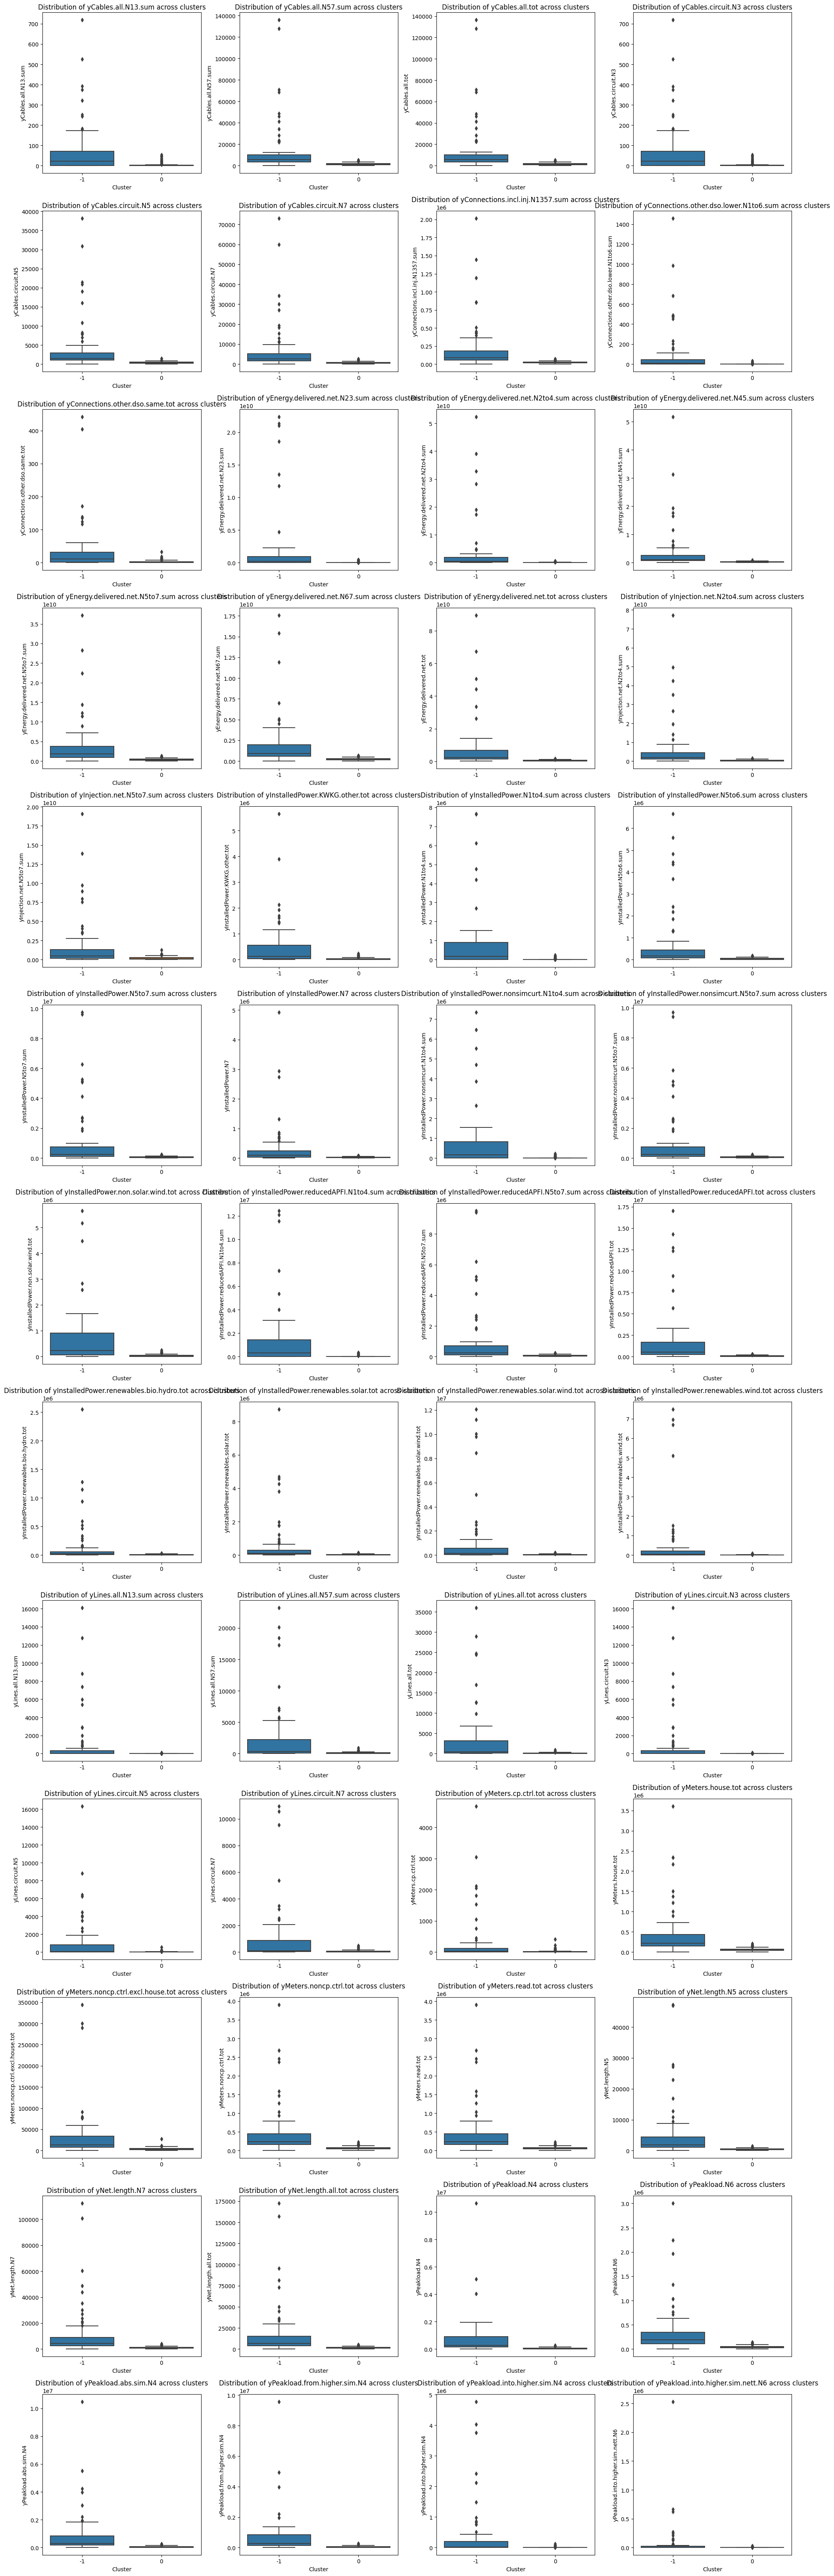

In [6]:
# Number of plots per row
plots_per_row = 4

# Calculate the number of rows needed
num_vars = len(technical_blocks_variables)
num_rows = math.ceil(num_vars / plots_per_row)

# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through variables and create box plots for each technical block variable
for i, var in enumerate(technical_blocks_variables):
    sns.boxplot(x='Cluster', y=var, data=df_train, ax=axes[i])
    axes[i].set_title(f'Distribution of {var} across clusters')

# Remove any empty subplots
for i in range(num_vars, num_rows * plots_per_row):
    fig.delaxes(axes[i])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

The box plots illustrate the distribution of each technical block variable across the identified clusters. As expected, **Cluster -1** (which is often considered noise in DBSCAN) generally represents networks with higher capacity and cost, indicated by the significantly higher values in most variables. **Cluster 0** corresponds to smaller networks with lower associated costs and capacities. These visualizations further confirm the differences between the clusters, supporting the idea that Cluster -1, despite being labeled as noise, captures a meaningful segment of larger, more complex networks.